# Demo of the `WaypointDiffusion2D` distribution

This notebook demonstrates the `WaypointDiffusion2D` distribution with a constrained waypoint grid by fitting a migration path between a know ancestor and know decendent. Our geometry forces the migration path to turn around a corner.

In [1]:
from tspyro.diffusion import make_hex_grid
import scipy
import torch
from tspyro.diffusion import ApproximateMatrixExponential
from tspyro.diffusion import WaypointDiffusion2D
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import torch

In [2]:
radius = 0.1
bounds = dict(west=-1, east=1, north=1, south=-1)
def on_land(x, y):
    return (x < -0.5) | (y > 0.5)
grid = make_hex_grid(**bounds, radius=0.1, predicate=on_land)
waypoints = grid["waypoints"]
transition = grid["transition"]

In [3]:
print(waypoints.shape)
print(transition.shape)

torch.Size([216, 2])
torch.Size([216, 216])


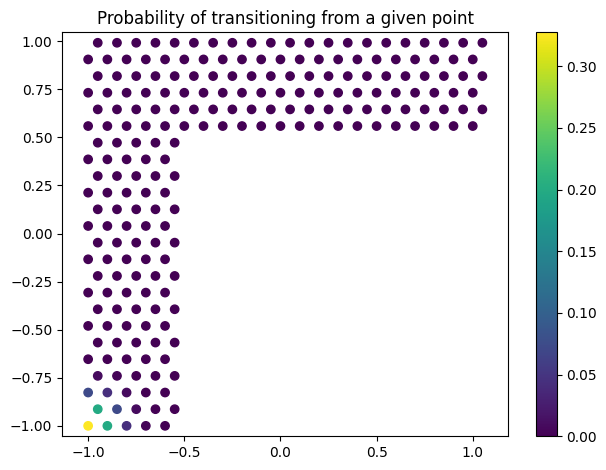

In [4]:
plt.title("Probability of transitioning from a given point")
plt.scatter(waypoints[:, 0], waypoints[:, 1], c=transition[0])
plt.xlim(bounds["west"], bounds["east"])
plt.ylim(bounds["south"], bounds["north"])
plt.axis("equal")
plt.colorbar()
plt.tight_layout()

In [5]:
batch_shape = ()
source = torch.randn(batch_shape + (2,)) + 2
destin = torch.randn(batch_shape + (2,)) + 2
time = 2.0
matrix_exp = ApproximateMatrixExponential(transition)

In [6]:
def model(num_edges=6):
    with pyro.plate("chain", num_edges - 1):
        points = pyro.sample("points", dist.Normal(0, 10).expand([2]).to_event(1))
    start = torch.tensor([[-1., -1.]])
    end = torch.tensor([[1., 1.]])
    with pyro.plate("edges", num_edges):
        heads = torch.cat([start, points])
        tails = torch.cat([points, end])
        pyro.sample(
            "walk",
            # dist.Normal(heads, radius * time**0.5).to_event(1),
            WaypointDiffusion2D(heads, time, radius, waypoints, matrix_exp),
            obs=tails,
        )

step 0 loss = 3599.29
step 100 loss = 1415.99
step 200 loss = 460.645
step 300 loss = 99.9877
step 400 loss = 56.6874
step 500 loss = 61.1159
step 600 loss = 55.1345
step 700 loss = 55.3014
step 800 loss = 54.9769
step 900 loss = 54.697
step 1000 loss = 55.1653


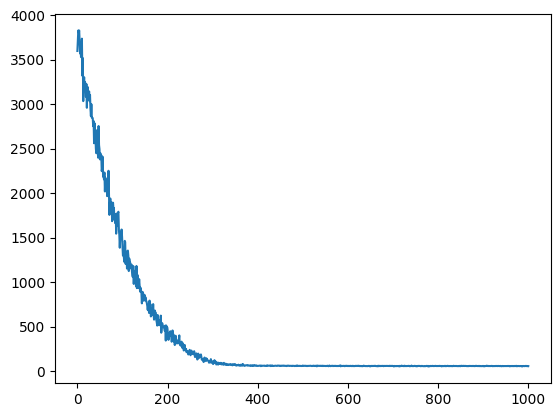

In [7]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoLowRankMultivariateNormal
from pyro.optim import ClippedAdam
pyro.clear_param_store()
guide = AutoLowRankMultivariateNormal(model)
optim = ClippedAdam({"lr": 0.01})
svi = SVI(model, guide, optim, Trace_ELBO())
losses = []
for step in range(1001):
    loss = svi.step()
    losses.append(loss)
    if step % 100 == 0:
        print(f"step {step} loss = {loss:0.6g}")
plt.plot(losses)

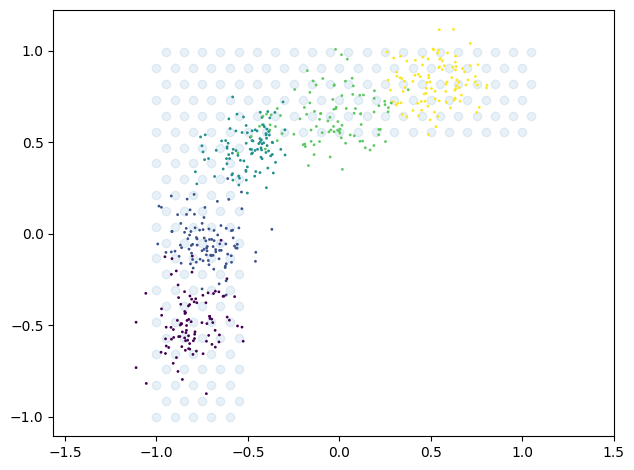

In [8]:
plt.scatter(waypoints[:, 0], waypoints[:, 1], alpha=0.1)
plt.xlim(bounds["west"], bounds["east"])
plt.ylim(bounds["south"], bounds["north"])
plt.axis("equal")
with torch.no_grad(), pyro.plate("particles", 100, dim=-2):
    points = guide()["points"]
X, Y = points.reshape(-1, 2).unbind(-1)
color = torch.arange(points.size(-2)).expand(points.shape[:-1]).reshape(-1)
plt.scatter(X.numpy(), Y.numpy(), s=1, c=color)
plt.tight_layout()